In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn.functional as F

import lava.lib.dl.slayer as slayer
import torch
import torchvision
from lava.lib.dl import netx

# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d
import numpy as np

random_seed = 18
import torch
torch.manual_seed(random_seed)
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)


In [2]:
def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val

In [3]:
# Get validation data
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        transforms.Lambda(lambda x: x.view(3, 1024).t())
    ])
transform_train = transform_test = transform

# Datasets
trainset = torchvision.datasets.CIFAR10(
    root='./data/cifar/', train=True, download=True, transform=transform_train)
trainset, val = split_train_val(trainset, val_split=0.1)

testset = torchvision.datasets.CIFAR10(
    root='./data/cifar/', train=False, download=True, transform=transform_test)

val_loader = torch.utils.data.DataLoader(dataset=val , batch_size=1, shuffle=True, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
label, data_sample = next(enumerate(val_loader))


In [41]:

# inp_exp = 9 #
data_rescaled = torch.transpose(data_sample[0], -1,-2)
diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
diff_inp = torch.from_numpy(np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2)) # Q-2.27


int_bits = np.ceil(np.log2(diff_inp.max()- diff_inp.min())).int().item()
inp_exp = 24 - 6 - int_bits - 1
# inp_exp = 13 #

print(inp_exp, int_bits, diff_inp.max()- diff_inp.min())

14 3 tensor(4.5505)


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


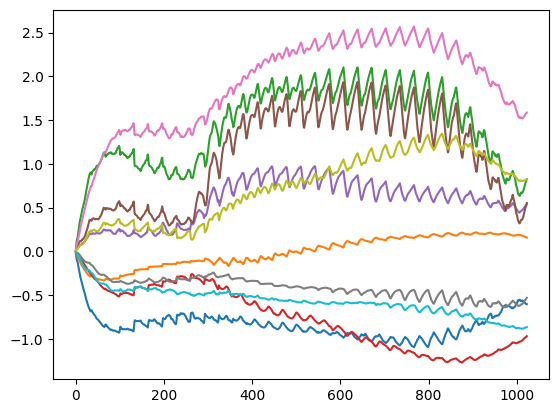

In [6]:
from lava.lib.dl.slayer.state_space_models.sCIFAR.network import SCIFARNetwork


# differences
n_states = 64
d_model = 64
lava_dl_model_untrained = SCIFARNetwork(d_model=d_model, n_states=n_states, num_layers=1)



lava_dl_model_untrained.eval();
out_dl_untrained = lava_dl_model_untrained(data_sample[0])

plt.plot(out_dl_untrained[0].T.detach().numpy());

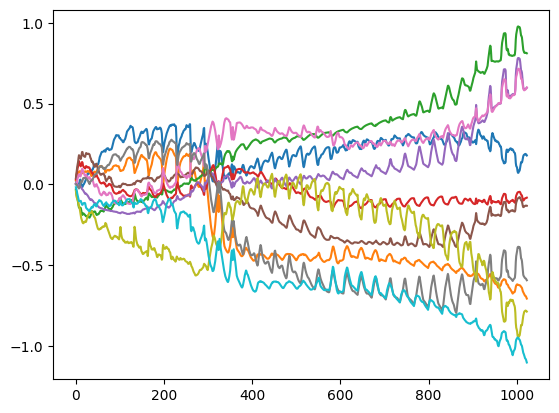

In [7]:
lava_dl_model_trained = SCIFARNetwork(d_model=d_model, n_states=n_states, num_layers=1)
lava_dl_model_trained.load_state_dict(torch.load("1_layer.pt"))
lava_dl_model_trained.blocks[2].neuron.activation.setup_step()

lava_dl_model_trained.eval();

out_dl_trained = lava_dl_model_trained(data_sample[0])


plt.plot(out_dl_trained[0].T.detach().numpy());

In [8]:
if os.path.exists("untrained.net"):
    os.remove("untrained.net")
lava_dl_model_untrained.export_hdf5("untrained.net")
num_message_bits = 24

loaded_net_untrained =  netx.hdf5.Network(net_config='untrained.net', input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
print(loaded_net_untrained)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1| 4096|     |     |     |     |     |False|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|


In [9]:
if os.path.exists("trained.net"):
    os.remove("trained.net")
lava_dl_model_trained.export_hdf5("trained.net")

loaded_net_trained =  netx.hdf5.Network(net_config='trained.net', input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
print(loaded_net_trained)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1| 4096|     |     |     |     |     |False|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|


In [10]:
# get output from loaded lava net
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.proc.dense.process import Dense
from lava.proc.s4d.ncmodels import NcModelSigmaS4dDelta
from lava.proc.s4d.process import SigmaS4dDelta
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
CompilerOptions.verbose = True
# Enable SLURM, the workload manager used to distribute Loihi2 resources to users
os.environ['SLURM'] = '1'
os.environ['PARTITION'] = "oheogulch"
os.environ['LOIHI_GEN'] = "N3B3"
    

def run_net(net):


    n_steps = 1024 + len(net)
    
    
    spiker = SourceBuffer(data=diff_inp.detach().numpy().reshape(3,1024) * 2**inp_exp)
    adapter_i = PyToNxAdapter(shape=(3,), num_message_bits=num_message_bits)
    adapter_o = NxToPyAdapter(shape=(10,), num_message_bits=num_message_bits)
    receiver = SinkBuffer(buffer = n_steps, shape=(10,))
    
    
    spiker.s_out.connect(adapter_i.inp)
    adapter_i.out.connect(net.inp)
    net.out.connect(adapter_o.inp)
    adapter_o.out.connect(receiver.a_in)
    
    run_cfg = Loihi2HwCfg()
    sigma = np.zeros(n_steps)
    S4state = np.zeros(n_steps)
    
    spiker.run(condition=RunSteps(num_steps=n_steps), run_cfg=Loihi2HwCfg())    
    received_data_lava = receiver.data.get()
    spiker.stop()
    out_lava = (received_data_lava.astype(np.int32) << 8) >> 8
    return out_lava  / 2**inp_exp / 2**6
    

In [11]:
out_lava_untrained = run_net(loaded_net_untrained)
out_lava_trained = run_net(loaded_net_trained)


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.40%|  12.50%|   0.24%|   1.20%|   0.06%|   0.00%|   1.39%|       1|
|   0.40%|  12.50%|   1.56%|   7.17%|   0.40%|   0.00%|   6.71%|       1|
|  25.60%|  12.50%|   1.56%|  25.60%|   0.40%|   0.00%|  41.61%|       1|
|   0.40%|  12.50%|  99.98%|   2.80%|  12.79%|   0.00%|  33.27%|       3|
|   0.02%|  12.50%|   1.56%|   0.34%|   0.40%|   0.00%|   0.93%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       7|
-------------------------------------------------------------------------
Partitioning converged after iteration=1
Per core utilization:
------------------------------------------------------------

In [12]:
def plot(dl, lava, net):
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    axs[0].plot(dl[0][:, :30].detach().numpy().T);
    axs[1].plot(lava[:, len(net):30+len(net):].T, label=range(10));
    axs[2].plot(dl[0].detach().numpy().T);
    axs[3].plot(lava[:, len(net):].T, label=range(10))
    axs[4].plot(dl[0].T.detach() - lava[:, len(net):].T);
    plt.legend();


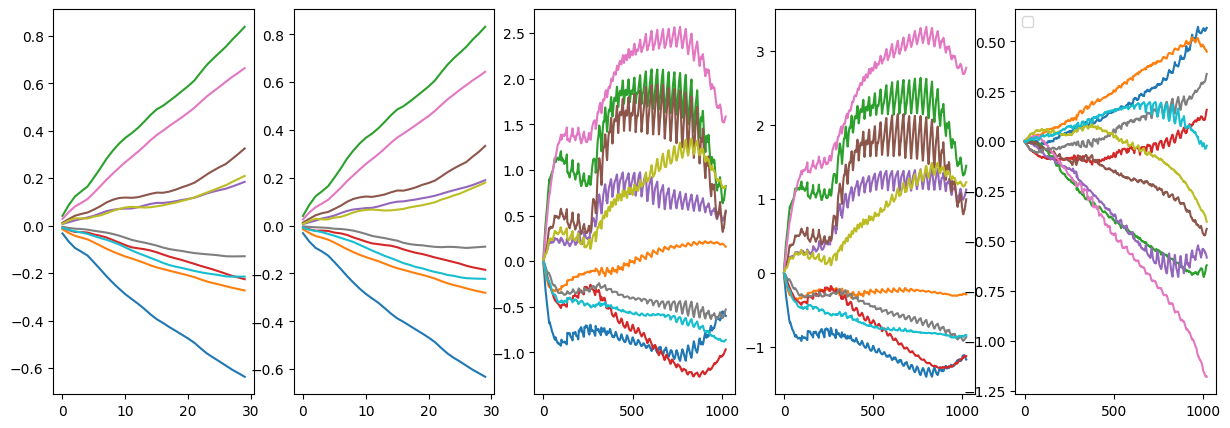

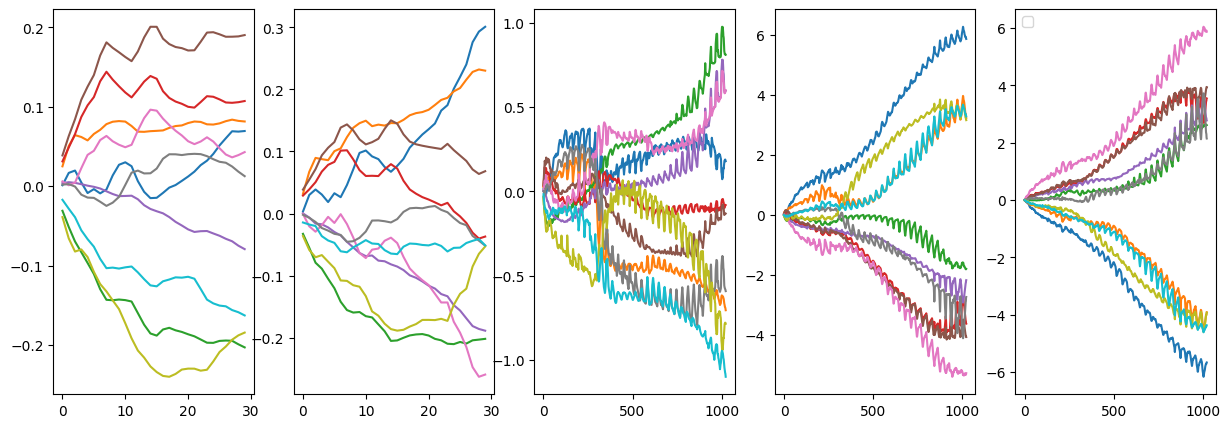

In [13]:
plot(out_dl_untrained, out_lava_untrained, loaded_net_untrained)
plot(out_dl_trained, out_lava_trained, loaded_net_trained)

In [14]:
def normalize(x, y):
    return x/y.abs().max()

gt = out_dl_untrained[0].detach()
lava = out_lava_untrained[:, len(loaded_net_untrained):]
error = ((normalize(gt, gt) - normalize(lava, gt))**2).mean()
print("MSE untrained", error) 
# FF  ws=1:   MSE tensor(0.0124, dtype=torch.float64)
# FF  ws=2:   MSE tensor(0.0094, dtype=torch.float64)
# FF  ws=3:   MSE tensor(0.0070, dtype=torch.float64)
# FF  ws=4:   MSE tensor(0.0071, dtype=torch.float64)
# S4D ws=2:   MSE tensor(0.0479, dtype=torch.float64)
# S4D ws=0.5  MSE tensor(0.1277, dtype=torch.float64)

# 8bit S4D_Exp w/o quantizing dl model: MSE tensor(0.0718, dtype=torch.float64)
# 8bit S4D_Exp with quantizing dl model: MSE tensor(0.0695, dtype=torch.float64)
# 8bit S4D_Exp with quantizing dl model (also input with 6 bit): MSE tensor(0.0696, dtype=torch.float64)
# 8bit S4D_Exp with quantizing dl model (also input with 1 bit): MSE tensor(0.1370, dtype=torch.float64)
# 8bit S4D_Exp with quantizing dl model (also input with 8 bit): MSE tensor(0.0694, dtype=torch.float64)

# 12 bit S4D_Exp with quantizing dl model (also input with 8 bit): MSE tensor(0.0009, dtype=torch.float64)
# 16 bit S4D_Exp with quantizing dl model (also input with 8 bit): MSE tensor(0.0537, dtype=torch.float64)


# inp_exp - 2: bad 
# -1: MSE tensor(2.1842, dtype=torch.float64)
# -3: MSE tensor(3.0030, dtype=torch.float64)
# -0: MSE tensor(0.7727, dtype=torch.float64)
# +1: MSE tensor(1.1630, dtype=torch.float64)

MSE untrained tensor(0.0145, dtype=torch.float64)


In [15]:


gt = out_dl_trained[0].detach()
lava = out_lava_trained[:, len(loaded_net_trained):]
error = ((normalize(gt, gt) - normalize(lava, gt))**2).mean()
print("MSE trained", error) 


MSE trained tensor(4.2285, dtype=torch.float64)


tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])
tensor(False)


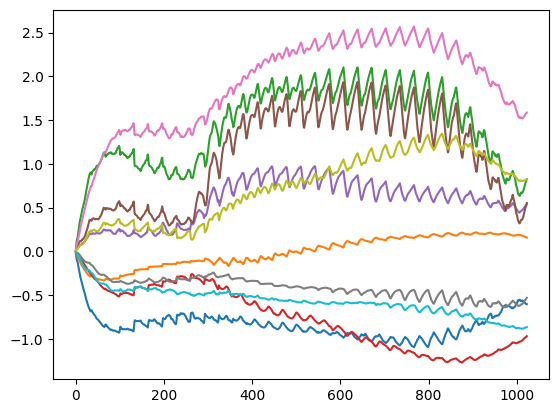

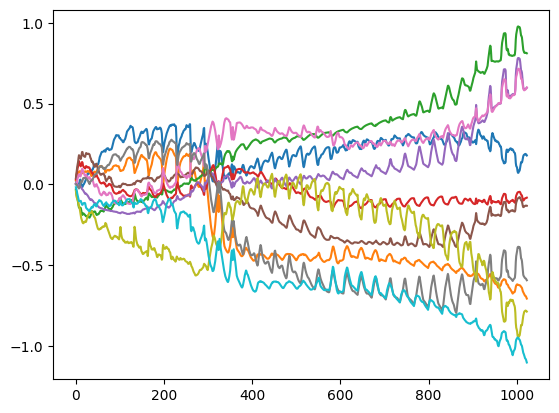

In [340]:
# Move layerwise parameters to untrained model
state_dict = lava_dl_model_untrained.state_dict()
lava_dl_model_merged = SCIFARNetwork(d_model=d_model, n_states=n_states, num_layers=1)
lava_dl_model_merged.load_state_dict(state_dict)
lava_dl_model_merged.blocks[2].neuron.activation.setup_step()

print(lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dA == lava_dl_model_untrained.blocks[2].neuron.activation.layer.kernel.dA)
print(lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dB == lava_dl_model_untrained.blocks[2].neuron.activation.layer.kernel.dB)
print(lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dC == lava_dl_model_untrained.blocks[2].neuron.activation.layer.kernel.dC)

# lava_dl_model_merged.blocks[1].synapse.weight.data = lava_dl_model_merged.blocks[1].synapse.weight.data * 4
# lava_dl_model_merged.blocks[4].synapse.weight.data = lava_dl_model_merged.blocks[4].synapse.weight.data * 4
# lava_dl_model_merged.blocks[5].synapse.weight.data = lava_dl_model_merged.blocks[5].synapse.weight.data * 4
# lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dA = lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dA * 3
# lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dB = lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dB * 3

lava_dl_model_merged.blocks[1].synapse.weight.data = lava_dl_model_trained.blocks[1].synapse.weight.data#.clamp(-.3, 0.3)
lava_dl_model_merged.blocks[4].synapse.weight.data = lava_dl_model_trained.blocks[4].synapse.weight.data#.clamp(-.3, 0.3)
lava_dl_model_merged.blocks[5].synapse.weight.data = lava_dl_model_trained.blocks[5].synapse.weight.data#.clamp(-.3, 0.3)

lava_dl_model_merged.blocks[2].neuron.activation.layer.D.data = lava_dl_model_trained.blocks[2].neuron.activation.layer.D.data # Doesn't matter as expected 
lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.inv_dt.data = lava_dl_model_trained.blocks[2].neuron.activation.layer.kernel.inv_dt.data
lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.C.data = lava_dl_model_trained.blocks[2].neuron.activation.layer.kernel.C.data
lava_dl_model_merged.blocks[2].neuron.activation.setup_step()

lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dA = lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dA.clamp(0.95, 1.0)
lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dB = lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dB.clamp(-0.05, 0.01)
# lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dC = lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dC.clamp(-3., 3.)

print(torch.all(lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dA == lava_dl_model_trained.blocks[2].neuron.activation.layer.kernel.dA))
print(torch.all(lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dB == lava_dl_model_trained.blocks[2].neuron.activation.layer.kernel.dB))
print(torch.all(lava_dl_model_merged.blocks[2].neuron.activation.layer.kernel.dC == lava_dl_model_trained.blocks[2].neuron.activation.layer.kernel.dC))

lava_dl_model_merged.eval();
out_dl_merged = lava_dl_model_merged(data_sample[0])

plt.plot(out_dl_untrained[0].T.detach().numpy());
plt.figure()
plt.plot(out_dl_merged[0].T.detach().numpy());

In [341]:
if os.path.exists("merged.net"):
    os.remove("merged.net")
lava_dl_model_merged.export_hdf5("merged.net")

loaded_net_merged =  netx.hdf5.Network(net_config='merged.net', input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
print(loaded_net_merged)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1| 4096|     |     |     |     |     |False|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1|   64|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|


In [342]:

# loaded_net_trained =  netx.hdf5.Network(net_config='trained.net', input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)


In [ ]:
inp_exp = 14

out_lava_merged = run_net(loaded_net_merged)
# out_lava_trained = run_net(loaded_net_trained)


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.40%|  12.50%|   0.24%|   1.46%|   0.06%|   0.00%|   1.59%|       1|
|   0.40%|  12.50%|   1.56%|   7.88%|   0.40%|   0.00%|   7.27%|       1|
|  25.60%|  12.50%|   1.56%|  25.60%|   0.40%|   0.00%|  41.61%|       1|
|   0.40%|  12.50%|  99.98%|   2.80%|  12.79%|   0.00%|  33.27%|       3|
|   0.02%|  12.50%|   1.56%|   0.36%|   0.40%|   0.00%|   0.95%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       7|
-------------------------------------------------------------------------


In [ ]:
plot(out_dl_untrained, out_lava_untrained, loaded_net_untrained)
plot(out_dl_merged, out_lava_merged, loaded_net_merged)
plot(out_dl_trained, out_lava_trained, loaded_net_trained)


In [ ]:
gt = out_dl_merged[0].detach()
lava = out_lava_merged[:, len(loaded_net_merged):]
error = ((normalize(gt, gt) - normalize(lava, gt))**2).mean()
print("MSE merged", error) 

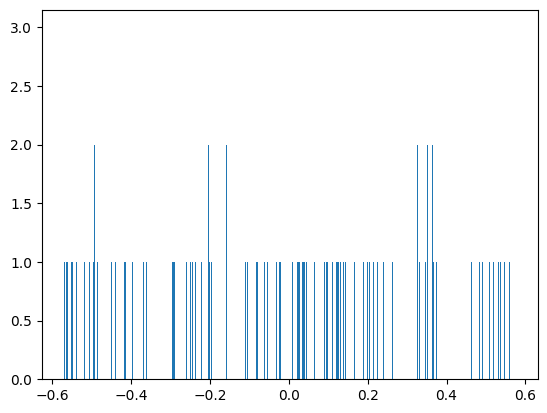

In [327]:
w_untrained = lava_dl_model_untrained.blocks[1].synapse.weight.flatten().detach().numpy() * 1
plt.hist(w_untrained, bins=1024);

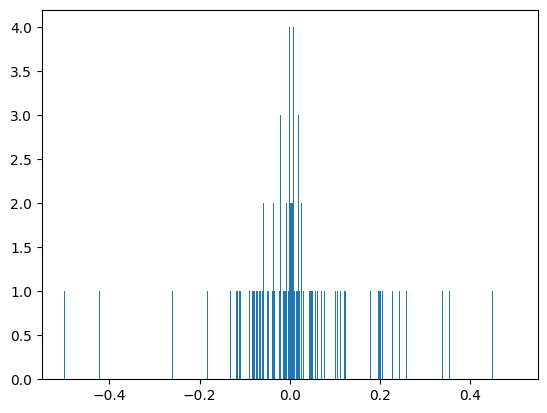

In [328]:
w_trained = lava_dl_model_trained.blocks[1].synapse.weight.flatten().detach().numpy() / 4
plt.hist(w_trained, bins=1024);

5.853424

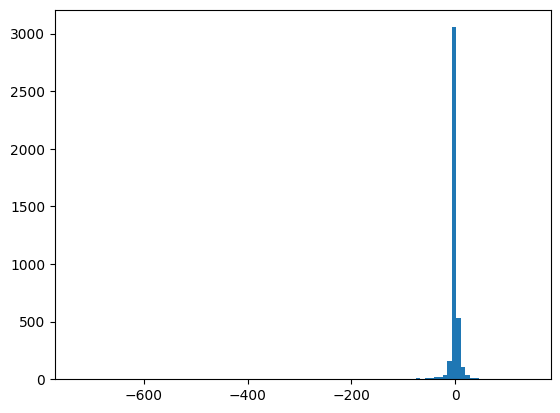

In [224]:
trained = lava_dl_model_trained.blocks[2].neuron.activation.layer.kernel.dB.data.flatten().detach().numpy() * 2** 12
plt.hist(trained, bins=100);
np.abs(trained).mean()

0.5542581

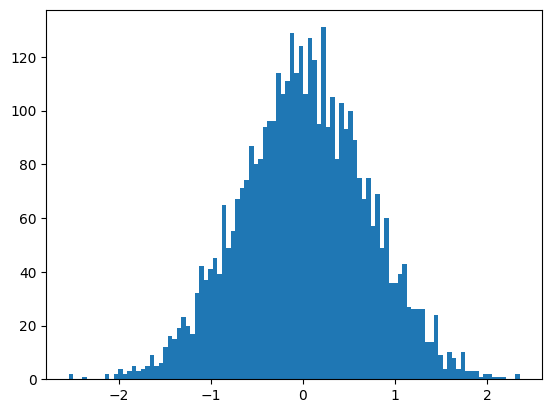

In [293]:
# new_rand = SCIFARNetwork(d_model=d_model, n_states=n_states, num_layers=1)

untrained = lava_dl_model_untrained.blocks[2].neuron.activation.layer.kernel.dC.data.flatten().detach().numpy()
plt.hist(untrained, bins=100);
np.abs(untrained).mean()

In [23]:
for i in range(len(loaded_net_merged.layers)):
    print(np.all(loaded_net_merged.layers[i].synapse.weights.init.toarray() == loaded_net_untrained.layers[i].synapse.weights.init.toarray()))

True
True
True
True
True


In [24]:
for i in range(len(loaded_net_merged.layers)):
    try:
        print(np.all(loaded_net_merged.layers[i].neuron.a.init == loaded_net_untrained.layers[i].neuron.a.init))
    except:
        pass

False


In [25]:
loaded_net_untrained.layers[0]

In [26]:
loaded_net_untrained.layers[1].neuron.a.init

array([4079, 4079, 4079, ..., 3958, 3958, 3958])

In [27]:
loaded_net_merged.layers[1].neuron.a.init

array([4081, 4081, 4081, ..., 4072, 4072, 4072])

In [28]:
state_dict = lava_dl_model_untrained.state_dict()
print(state_dict['blocks.2.neuron.activation.layer.kernel.C'].flatten())
state_dict = lava_dl_model_trained.state_dict()
print(state_dict['blocks.2.neuron.activation.layer.kernel.C'].flatten())

[s for s in state_dict]

tensor([ 0.2756,  1.2146,  1.1154,  ...,  0.7781,  0.5506, -0.7521])
tensor([ 0.4266,  0.2275,  0.4713,  ...,  0.8457,  1.1338, -0.7553])


['blocks.0.neuron.bias',
 'blocks.0.neuron.delta.threshold',
 'blocks.1.neuron.bias',
 'blocks.1.neuron.delta.threshold',
 'blocks.1.synapse.weight',
 'blocks.2.neuron.bias',
 'blocks.2.neuron.activation.layer.D',
 'blocks.2.neuron.activation.layer.kernel.inv_dt',
 'blocks.2.neuron.activation.layer.kernel.C',
 'blocks.2.neuron.activation.layer.kernel.B',
 'blocks.2.neuron.activation.layer.kernel.A_real',
 'blocks.2.neuron.activation.layer.kernel.dC',
 'blocks.2.neuron.delta.threshold',
 'blocks.2.synapse.weight',
 'blocks.3.neuron.bias',
 'blocks.3.neuron.delta.threshold',
 'blocks.3.synapse.weight',
 'blocks.4.neuron.bias',
 'blocks.4.neuron.delta.threshold',
 'blocks.4.synapse.weight',
 'blocks.5.neuron.bias',
 'blocks.5.neuron.delta.threshold',
 'blocks.5.synapse.weight']

In [29]:
lava_dl_model_merged.blocks[2].neuron.activation.setup_step()

In [30]:
# state_dict = lava_dl_model_merged.state_dict()
[s for s in state_dict]

['blocks.0.neuron.bias',
 'blocks.0.neuron.delta.threshold',
 'blocks.1.neuron.bias',
 'blocks.1.neuron.delta.threshold',
 'blocks.1.synapse.weight',
 'blocks.2.neuron.bias',
 'blocks.2.neuron.activation.layer.D',
 'blocks.2.neuron.activation.layer.kernel.inv_dt',
 'blocks.2.neuron.activation.layer.kernel.C',
 'blocks.2.neuron.activation.layer.kernel.B',
 'blocks.2.neuron.activation.layer.kernel.A_real',
 'blocks.2.neuron.activation.layer.kernel.dC',
 'blocks.2.neuron.delta.threshold',
 'blocks.2.synapse.weight',
 'blocks.3.neuron.bias',
 'blocks.3.neuron.delta.threshold',
 'blocks.3.synapse.weight',
 'blocks.4.neuron.bias',
 'blocks.4.neuron.delta.threshold',
 'blocks.4.synapse.weight',
 'blocks.5.neuron.bias',
 'blocks.5.neuron.delta.threshold',
 'blocks.5.synapse.weight']

In [31]:
state_dict['blocks.2.neuron.activation.layer.kernel.A'] = state_dict['blocks.2.neuron.activation.layer.kernel.A_real']

In [32]:
for i in range(len(lava_dl_model_trained.blocks)):
    trained_params = list(lava_dl_model_trained.blocks[i].named_parameters())
    merged_params = list(lava_dl_model_merged.blocks[i].named_parameters())
    for j, _ in enumerate(trained_params):
        same = torch.all(trained_params[j][1] == merged_params[j][1])
        print(same)
        if not same:
            print(trained_params[j][0], i, j)
        # print(torch.all(lava_dl_model_merged.blocks[i].parameters() == lava_dl_model_trained.blocks[i].synapse.parameters()))
        # print(torch.all(lava_dl_model_merged.blocks[i].neuron.parameters() == lava_dl_model_trained.blocks[i].neuron.parameters()))
        # print(torch.all(lava_dl_model_merged.blocks[i].synapse.weight.data == lava_dl_model_trained.blocks[i].synapse.weight.data))


# print(torch.all(lava_dl_model_merged.blocks[4].synapse.weight.data == lava_dl_model_trained.blocks[4].synapse.weight.data))
# print(torch.all(lava_dl_model_merged.blocks[5].synapse.weight.data == lava_dl_model_trained.blocks[5].synapse.weight.data))


tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(False)
synapse.weight 1 2
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(False)
synapse.weight 4 2
tensor(True)
tensor(True)
tensor(False)
synapse.weight 5 2


In [33]:
list(lava_dl_model_trained.blocks[2].named_parameters())[3]

('neuron.activation.layer.kernel.C',
 Parameter containing:
 tensor([[[ 0.4266,  0.2275,  0.4713,  ...,  1.5911, -0.7195, -0.8869],
          [-0.9977, -0.2247,  0.4176,  ..., -0.4328, -0.0645, -0.1614],
          [-0.0820,  0.0138,  0.3179,  ..., -0.9475,  0.7498, -0.9134],
          ...,
          [ 0.3957, -0.0482, -0.6305,  ...,  0.3437,  0.5360, -1.6677],
          [-0.3664,  0.0371, -0.7757,  ..., -0.0167,  0.2058, -1.3094],
          [-0.4209,  0.3605, -0.1799,  ...,  0.8457,  1.1338, -0.7553]]],
        requires_grad=True))

In [34]:
list(lava_dl_model_untrained.blocks[2].named_parameters())[3]

('neuron.activation.layer.kernel.C',
 Parameter containing:
 tensor([[[ 0.2756,  1.2146,  1.1154,  ..., -0.2078, -0.4050,  0.3844],
          [-0.8611,  0.1085,  0.1881,  ...,  0.2348,  0.2317,  0.6325],
          [ 0.0758,  0.1415,  0.5896,  ..., -0.9714,  0.3371, -0.0695],
          ...,
          [-0.3761, -0.3156,  0.2448,  ...,  0.1352,  1.4692,  0.1536],
          [ 0.3029,  0.9106, -0.1221,  ...,  0.7527, -0.2465,  0.5348],
          [ 0.6429, -0.0703,  0.8623,  ...,  0.7781,  0.5506, -0.7521]]],
        requires_grad=True))

In [35]:
out_lava[:, -1].argsort()

NameError: name 'out_lava' is not defined

In [ ]:
data_sample[1]

In [ ]:
a[0][:, -1].argsort()

In [ ]:

preds = []
preds_dl = []
tgts = []
for batch_idx, [inp, tgt] in enumerate(val_loader):
    break
    CompilerOptions.verbose = False

    # inp_exp = 13
    data_rescaled = torch.transpose(inp, -1,-2)
    diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
    diff_inp = torch.from_numpy(np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2))
    int_bits = np.ceil(np.log2(diff_inp.max()- diff_inp.min())).int().item()
    inp_exp = 24 - 6 - int_bits - 3


    tgts.append(tgt.item())
    # lava_dl_model = SCIFARNetwork(d_model=d_model, n_states=n_states)
    # lava_dl_model.load_state_dict(torch.load("1_layer.pt"))
    # lava_dl_model.eval()
    
    out_dl = lava_dl_model(inp)
    pred_dl = out_dl[0].mean(-1).argmax().item()

    preds_dl.append(pred_dl)

    loaded_net =  netx.hdf5.Network(net_config='debug.net', input_message_bits=24, sparse_fc_layer=True, skip_layers=1)
    n_steps = 1024 + len(loaded_net)
    
    spiker = SourceBuffer(data=diff_inp.detach().numpy().reshape(3,1024) * 2**inp_exp)
    adapter_i = PyToNxAdapter(shape=(3,), num_message_bits=24)
    adapter_o = NxToPyAdapter(shape=(10,), num_message_bits=24)
    receiver = SinkBuffer(buffer = n_steps, shape=(10,))
    
    
    spiker.s_out.connect(adapter_i.inp)
    adapter_i.out.connect(loaded_net.inp)
    loaded_net.out.connect(adapter_o.inp)
    adapter_o.out.connect(receiver.a_in)
    run_cfg = Loihi2HwCfg()
    spiker.run(condition=RunSteps(num_steps=n_steps), run_cfg=Loihi2HwCfg()) 
    received_data_lava = receiver.data.get()
    spiker.stop()
    out_lava = (received_data_lava.astype(np.int32) << 8) >> 8
    pred_lava = out_lava.mean(-1).argmax()
    preds.append(pred_lava)


    
    print(batch_idx, tgt, pred_dl, pred_lava)
    if batch_idx > 100:
        break


In [ ]:
print(tgts, preds_dl, preds)


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(tgts, preds_dl)

In [ ]:
accuracy_score(tgts[:-1], preds)

In [ ]:
accuracy_score(preds_dl[:-1], preds)

In [ ]:
w = lava_dl_model.blocks[-1].synapse.weight.flatten().detach().numpy() * 1

In [ ]:
plt.hist(w, bins=1024);

In [ ]:
plt.hist((w* 64).astype(int), bins=256, range=(-128, 128));

In [ ]:
scale = 128 / (np.abs(w).std() * 3)
plt.hist((w* scale).astype(int), bins=256, range=(-128, 128));

In [ ]:
w.max()

In [ ]:
w.min()

In [ ]:
scale

In [ ]:
s4d= lava_dl_model.blocks[2].neuron.activation

In [ ]:
a = s4d.layer.kernel.dA.detach().numpy().flatten()
b = s4d.layer.kernel.dB.detach().numpy().flatten()
c = s4d.layer.kernel.dC.detach().numpy().flatten()

In [ ]:
plt.hist(a, bins=1024);

In [ ]:
plt.hist(b, bins=1024);

In [ ]:
plt.hist(c, bins=1024);